### **Introdcution**

This brief notebook will show the process of applying simple deep learning model with using Keras to predict heavy rain in Northen Germany. \
The remainder of the Notebook is organized as follows. \
1. Environment set up and package loading; \
2. Station selection and data preprocess; \
3. Creation of training, validation and test datasets; \
4. Models setup; \
5. Assessment of trained models with the test set. \

In [19]:
# access metadata files from google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

!ls gdrive

Mounted at /content/gdrive
MyDrive


In [20]:
import sys
working_folder = '/content/gdrive/MyDrive/Germany_forecast_test/'
sys.path.append(working_folder)

In [21]:
# tensorflow packages
import tensorflow
from tensorflow.keras.layers import Input, Dense, SimpleRNN, GRU, LSTM, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from re import VERBOSE

# general packages
!pip install geopandas matplotlib
import geopandas as gpd
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import datetime, os
import itertools
import time
import math

### **Station selection and data preprocessing**


The Dataset comes from the Global Historical Climatology Network daily (GHCNd),
accessed from the website (https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily). \
In this notebook, 10 stations in the northen region are selected, and some related spatial information are shown below. And 15 years of daily precipitation was downloaded as model input (2009-03-31 to 2024-03-31). \
The unit of daily precipitation is inferred as inches. As the target unit of rainfall should be mm/d, the unit conversion is required.

<ipython-input-22-676ff9e7673e>:11: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


Text(0.5, 1.0, '10 target Germany Stations')

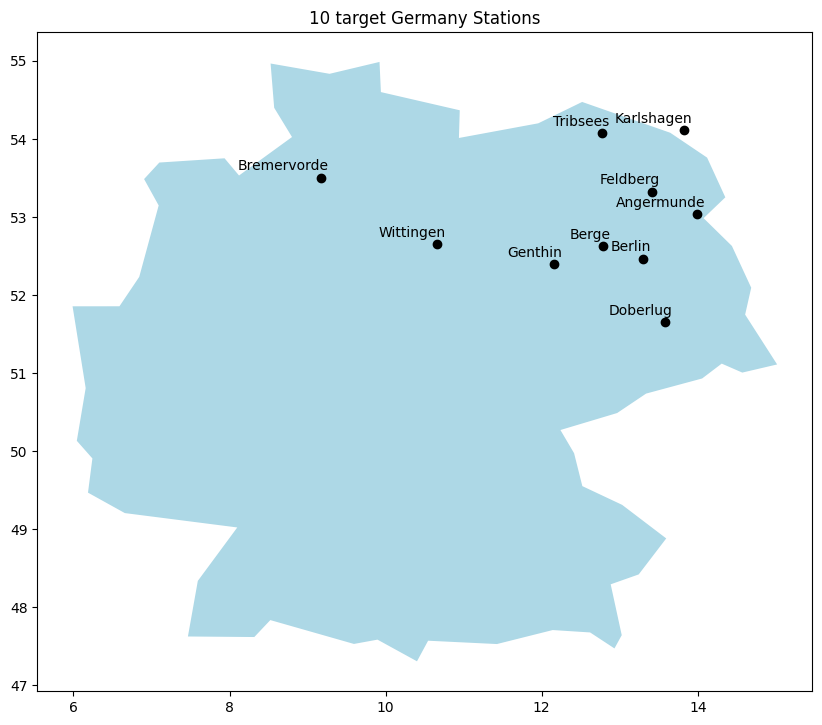

In [22]:
# 10 Selected Station Data
station_df = pd.DataFrame({
    'station': ['Berlin', 'Angermunde', 'Feldberg', 'Karlshagen', 'Tribsees', 'Bremervorde', 'Genthin', 'Wittingen', 'Doberlug', 'Berge'],
    'Latitude': [52.4639, 53.0331, 53.3175, 54.1064, 54.0681, 53.4989, 52.3892, 52.6439, 51.6467, 52.6206],
    'Longitude': [13.3017, 13.9931, 13.4175, 13.8258, 12.7689, 9.1731, 12.1633, 10.6642, 13.5767, 12.7889],
    'Elevation': [51, 54, 115, 1, 10, 3, 35, 72, 97, 40]
})
geo_df = gpd.GeoDataFrame(station_df, geometry = gpd.points_from_xy(station_df.Longitude, station_df.Latitude))

# Load the country map and visualize station location
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
GM = world[world.name == 'Germany'].plot(color='lightblue', figsize=(10, 15))
geo_df.plot(ax=GM, color='black')
offset = 0.1 # to avoid overlap between names and dots, and improve readability
for x, y, label in zip(geo_df.geometry.x, geo_df.geometry.y, geo_df['station']):
  GM.text(x + offset, y + offset, label, fontsize=10, ha='right')
plt.title('10 target Germany Stations')

In [23]:
# load data
filename = 'DailyRain_10GM_15years.csv'
df = pd.read_csv(working_folder+filename, parse_dates=[5], skipinitialspace=True)
df.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,TMAX,TMIN
0,GME00129418,TRIBSEES,54.0681,12.7689,10,2009-03-31,0.0,52.0,33.0
1,GME00129418,TRIBSEES,54.0681,12.7689,10,2009-04-01,0.0,49.0,35.0
2,GME00129418,TRIBSEES,54.0681,12.7689,10,2009-04-02,0.0,59.0,34.0
3,GME00129418,TRIBSEES,54.0681,12.7689,10,2009-04-03,0.0,66.0,30.0
4,GME00129418,TRIBSEES,54.0681,12.7689,10,2009-04-04,0.0,71.0,33.0


In [24]:
# change data units FROM 'Inches' and 'Fahrenheit' TO 'mm/d' and 'degree'
df.loc[:, 'PRCP'] = df.loc[:, 'PRCP'] * 25.4
df.loc[:, 'TMAX'] = (df.loc[:, 'TMAX'] - 32) * 5 / 9
df.loc[:, 'TMIN'] = (df.loc[:, 'TMIN'] - 32) * 5 / 9
df[['TMAX', 'TMIN']] = df[['TMAX', 'TMIN']].round(2)
df.tail()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,TMAX,TMIN
54779,GME00132322,WITTINGEN VORHOP,52.6439,10.6642,72,2024-03-27,4.826,17.22,2.22
54780,GME00132322,WITTINGEN VORHOP,52.6439,10.6642,72,2024-03-28,1.270,12.22,5.56
54781,GME00132322,WITTINGEN VORHOP,52.6439,10.6642,72,2024-03-29,2.286,14.44,6.11
54782,GME00132322,WITTINGEN VORHOP,52.6439,10.6642,72,2024-03-30,0.000,19.44,7.22
54783,GME00132322,WITTINGEN VORHOP,52.6439,10.6642,72,2024-03-31,0.000,15.56,7.22


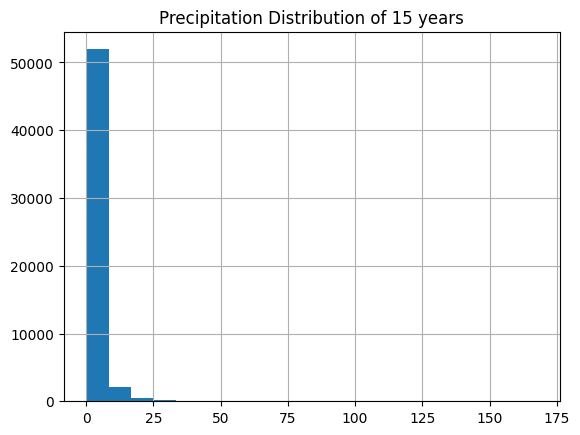

In [25]:
# Visualization and distribution of rainfall dataset
Rain_dict = df['PRCP']
hist = df['PRCP'].hist(bins=20) #Rain_dict.hist
plt.title('Precipitation Distribution of 15 years')
plt.show()

In [26]:
#calculate the number of heavy rain day in these 10 stations within 15 years

number_heavy_day = (df['PRCP'] > 10).sum()
number_norain_day = (df['PRCP'] == 0).sum()

print('Dates with heavy rain (10mm/d):',number_heavy_day, 'days in 15 years')
print('Dates withour rain:', number_norain_day, 'days in 15 years')

Dates with heavy rain (10mm/d): 1994 days in 15 years
Dates withour rain: 31388 days in 15 years


### **Creation of training, validation and test datasets**
Now create the final training datasets that you will be using for the models, by following these steps: \
1) Each input entry of the dataset will be a sequence of lenght  L=7. \
2) The training and validation set periord spans from 2009-03-31 to 2022-03-31; the remaining data from 2022 are used for testing.  \
3) To improve model capability of better predicting heavy precipitation event, setting a minimal rainrate threshold. The precipitation sequence with a target value of rainfall larger than the threshold will be selected into training or testing datasets. \
4) Remove input sequences containing NaN values. \
5) Shuffle the dataset.


In [27]:
# the whole dataset is from 2009-03-31 to 2024-03-31, 15 years in total
start_date = pd.to_datetime('2009-04-07')
test_date = pd.to_datetime('2022-03-31') # the starting date of the test set
mask_train = (df['DATE'] > start_date) & (df['DATE'] < test_date) & (df['PRCP'] > 5) # minimal threshold for training dataset is 5 mm/d
mask_test = (df['DATE'] > test_date) & (df['PRCP'] > 10) # minimal threshold for training dataset is 10 mm/d, to assess how well model can predict heavy rain events
rainlist_train = df.index[mask_train].tolist()
rainlist_test = df.index[mask_test].tolist()
#print(len(rainlist_train))
#print(len(rainlist_test))

#normalization
#df.loc[:,'PRCP'] = np.log(1+df.loc[:,'PRCP'])
#df.loc[:,'PRCP'] = df.loc[:,'PRCP']/df.loc[:,'PRCP'].max()

X = []
Y = []
random.shuffle(rainlist_train)

Nan_num = 0
for i in rainlist_train:
  whole_seq = df['PRCP'].iloc[i-7:i+1].values.reshape(-1, 1) # extract 7 input and 1 predicted value
  if any(math.isnan(x) for x in whole_seq) == True:
    Nan_num += 1
  else:
    rain_seq = df['PRCP'].iloc[i-7:i].values.reshape(-1, 1)
    pre_rain = df['PRCP'].iloc[i]
    X.append(rain_seq)
    Y.append(pre_rain)

X = np.array(X)
Y = np.array(Y)
print('Shape of input training and validation sets', X.shape, Y.shape)
print('average of training Y', np.mean(Y))

# intermediate check whether there is Nan in the selected precipitation data
#has_nan = np.isnan(X).any()
#print(has_nan)

#nan_count = np.isnan(X).sum()
#print(nan_count)

<ipython-input-27-21b0f0a3f44c>:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if any(math.isnan(x) for x in whole_seq) == True:


Shape of input training and validation sets (4646, 7, 1) (4646,)
average of training Y 10.838463194145502


In [37]:
# Test Data
#test_df = df[mask_test]
#display(test_df)
T_x = []
T_y = []
random.shuffle(rainlist_test)

for i in rainlist_test:
  whole_seq = df['PRCP'].iloc[i-7:i+1].values.reshape(-1, 1) # extract 7 input and 1 predicted value
  if any(math.isnan(x) for x in whole_seq) == False:
    test_seq = df['PRCP'].iloc[i-7:i].values.reshape(-1, 1)
    pre_test = df['PRCP'].iloc[i]
    T_x.append(test_seq)
    T_y.append(pre_test)
  if len(T_y)==20: # limit number of tested events to 20, for comparison and visualization
    break

T_x = np.array(T_x)
T_y = np.array(T_y)
print(T_x.shape, T_y.shape)

(20, 7, 1) (20,)


<ipython-input-37-8617c5e749fc>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if any(math.isnan(x) for x in whole_seq) == False:


### **Models Set up**
In this notebook, three simple deep learning models are tested and assessed. \
1) RNN with 'relu' as activation function; \
2) LSTM with 'relu' as activation function; \
3) LSTM with 'tanh' as activation function;

In [29]:
# Parameters
U = 20 # units in hidden layer
LR = 0.01 # learning rate
BS = 20 # batch size
IT = 100 # Iteration

def scheduler(epoch, lr):
    if epoch == 50:
      return lr * 0.1
    else:
      return lr

lr_schedule = LearningRateScheduler(scheduler)

In [30]:
# RNN model with relu activation
i = Input(shape=(7,1))
x = SimpleRNN(U, activation='relu')(i)
x = Dense(1)(x)
model = Model(i,x)
print(model.summary())

model.compile(
    loss='mean_squared_error',
    optimizer=Adam(learning_rate=LR),
    metrics = 'mean_squared_error',
)

# train
r_RNN_01 = model.fit(
    X, Y,
    epochs=IT, batch_size=BS,
    validation_split=0.2, verbose=0, callbacks=[lr_schedule])

model.save('RNN.keras')

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 7, 1)]            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20)                440       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 461 (1.80 KB)
Trainable params: 461 (1.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [31]:
# LSTM model with relu activation
i = Input(shape=(7,1))
x = LSTM(U, activation='relu')(i)
x = Dense(1)(x)
model = Model(i,x)
print(model.summary())

model.compile(
    loss='mean_squared_error',
    optimizer=Adam(learning_rate=LR),
    metrics = 'mean_squared_error',
)

# train
r_LSTM = model.fit(
    X, Y,
    epochs=IT, batch_size=BS,
    validation_split=0.2, verbose=0, callbacks=[lr_schedule])

model.save('LSTM.keras')

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 7, 1)]            0         
                                                                 
 lstm_2 (LSTM)               (None, 20)                1760      
                                                                 
 dense_4 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1781 (6.96 KB)
Trainable params: 1781 (6.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [32]:
# LSTM model with tanh activation
i = Input(shape=(7,1))
x = LSTM(U)(i)
x = Dense(1)(x)
model = Model(i,x)
print(model.summary())

model.compile(
    loss='mean_squared_error',
    optimizer=Adam(learning_rate=LR),
    metrics = 'mean_squared_error',
)

# train
r_LSTM_tanh = model.fit(
    X, Y,
    epochs=IT, batch_size=BS,
    validation_split=0.2, verbose=0, callbacks=[lr_schedule])

model.save('LSTM_tanh.keras')

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 7, 1)]            0         
                                                                 
 lstm_3 (LSTM)               (None, 20)                1760      
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1781 (6.96 KB)
Trainable params: 1781 (6.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


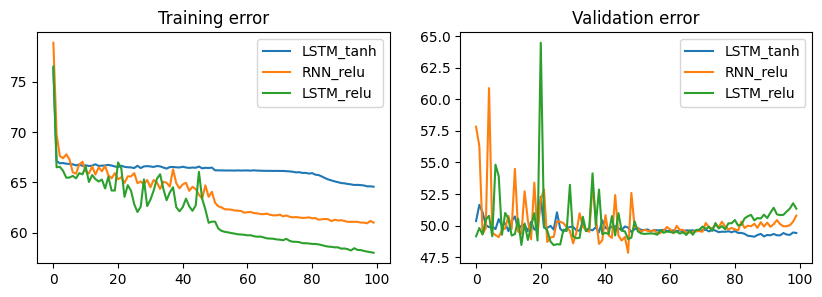

In [33]:
# setup learning curves plots
f, axes = plt.subplots(1,2,figsize=(10,3))

# plot training loss
axes[0].plot(r_LSTM_tanh.history['loss'], label ='LSTM_tanh')
axes[0].plot(r_RNN_01.history['loss'], label =f'RNN_relu')
axes[0].plot(r_LSTM.history['loss'], label ='LSTM_relu')
axes[0].set_title('Training error')
axes[0].legend()

# plot validation loss
axes[1].plot(r_LSTM_tanh.history['val_loss'], label ='LSTM_tanh')
axes[1].plot(r_RNN_01.history['val_loss'], label ='RNN_relu')
axes[1].plot(r_LSTM.history['val_loss'], label ='LSTM_relu')
axes[1].set_title('Validation error')
axes[1].legend()

### **Assessment of trained models with the test set**

1/1 [==============================] - 1s 596ms/step


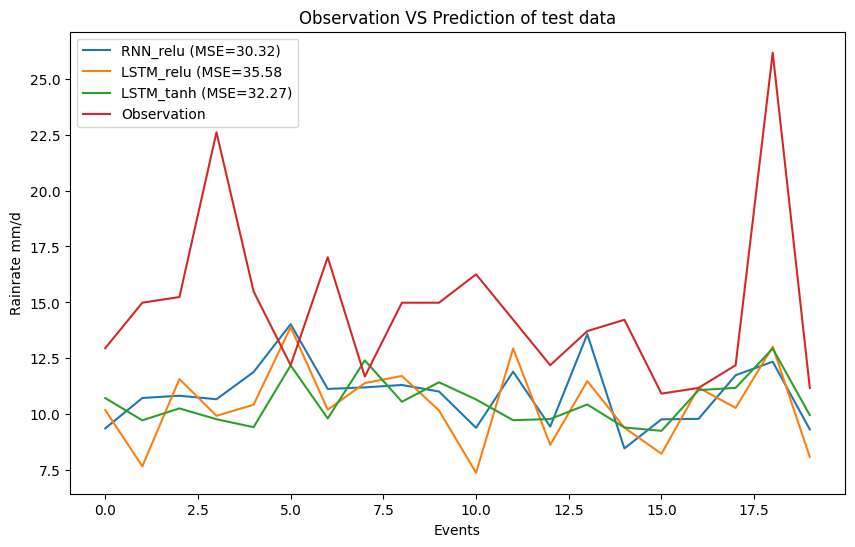

In [38]:
# Assessment with test data between different models
# RNN
rnn = tensorflow.keras.models.load_model('RNN.keras')
predict_rnn = rnn.predict(T_x)
mse_rnn = np.mean((T_y - predict_rnn)**2)

# LSTM (activation - relu)
lstm = tensorflow.keras.models.load_model('LSTM.keras')
predict_lstm = lstm.predict(T_x)
mse_lstm = np.mean((T_y - predict_lstm)**2)

# LSTM (activation = tanh)
lstm_tanh = tensorflow.keras.models.load_model('LSTM_tanh.keras')
predict_lstm_tanh = lstm_tanh.predict(T_x)
mse_lstm_tanh = np.mean((T_y - predict_lstm_tanh)**2)

plt.figure(figsize=(10, 6))

plt.plot(predict_rnn, label=f'RNN_relu (MSE={mse_rnn:.2f})')
plt.plot(predict_lstm, label=f'LSTM_relu (MSE={mse_lstm:.2f}')
plt.plot(predict_lstm_tanh, label=f'LSTM_tanh (MSE={mse_lstm_tanh:.2f})')
plt.plot(T_y, label='Observation')

plt.xlabel('Events')
plt.ylabel('Rainrate mm/d')
plt.title('Observation VS Prediction of test data')
plt.legend()
plt.show()
